In [118]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jre_utils.datapath import model_ready_data_paths

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay, r2_score

from jre_utils.datapath import WEIGHTS_DIRECTORY_PATH

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [119]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = "median"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
upcoming_metric_pct_chg = "upcoming_" + metric_pct_chg
normalized_upcoming_metric_pct_chg = "normalized_" + "upcoming_" + metric_pct_chg

In [120]:
dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"xgb_{dataset_key}_{metric_key}"]

df = pd.read_csv(model_ready_data_path)
df[normalized_upcoming_metric_pct_chg] = df.groupby("year")[
    upcoming_metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

In [121]:
# combined_df = pd.DataFrame()
# for key in ["transactions", "lpa", "plps"]:
#     tmp_df = pd.read_csv(model_ready_data_paths[f"xgb_{key}_{metric_key}"])
#     tmp_df[normalized_upcoming_metric_pct_chg] = tmp_df.groupby("year")[
#         upcoming_metric_pct_chg
#     ].transform(lambda x: (x - x.mean()) / x.std())
#     combined_df = pd.concat([combined_df, tmp_df])


In [122]:
# y_columns = [upcoming_metric_pct_chg]
y_columns = [normalized_upcoming_metric_pct_chg]

X_categorical_columns = ["area_code", "area"]

X_basic_columns = [
    "year",
    "population",
    "count",
    # "taxable_income_per_taxpayer",
    # "taxable_income_per_taxpayer_growth",
    "total_tax",
    "migrations_is_available",
    # "taxable_income_is_available",
    "total_tax_is_available",
    "dwellings_is_available",
]

X_engineering_columns = [
    "net_migration_ratio",
    # "taxable_income_growth",
    "new_dwellings_ratio",
    "total_tax_growth",
    metric_pct_chg,
]

X_engineered_columns = [
    "net_migration_ratio_ma3",
    "net_migration_ratio_cumu3",
    "net_migration_ratio_lag1",
    # "taxable_income_growth_ma3",
    # "taxable_income_growth_cumu3",
    # "taxable_income_growth_lag1",
    "new_dwellings_ratio_ma3",
    "new_dwellings_ratio_cumu3",
    "new_dwellings_ratio_lag1",
    "total_tax_growth_ma3",
    "total_tax_growth_cumu3",
    "total_tax_growth_lag1",
    "unit_price_median_pct_chg_ma3",
    "unit_price_median_pct_chg_cumu3",
    "unit_price_median_pct_chg_lag1",
]

X_columns = (
    X_categorical_columns
    + X_basic_columns
    + X_engineering_columns
    + X_engineered_columns
)

In [123]:
divide_year = 2020 # test_years = [2021]
train_df = df[df["year"] <= divide_year]
# train_df = combined_df[combined_df["year"] <= divide_year]
test_df = df[df["year"] > divide_year]

drop_columns = ["year", "area_code", "area"]
X_train_df, X_test_df = train_df[X_columns].drop(columns=drop_columns), test_df[X_columns].drop(columns=drop_columns)
y_train_df, y_test_df = train_df[y_columns], test_df[y_columns]

In [124]:
test_df

,area_code,area,year,population,count,total_traded_area,taxable_income_per_taxpayer,taxable_income_per_taxpayer_growth,total_tax,migrations_is_available,taxable_income_is_available,total_tax_is_available,dwellings_is_available,net_migration_ratio,taxable_income_growth,new_dwellings_ratio,total_tax_growth,unit_price_median_pct_chg,upcoming_unit_price_median_pct_chg,multiplier,net_migration_ratio_ma3,net_migration_ratio_cumu3,net_migration_ratio_lag1,taxable_income_growth_ma3,taxable_income_growth_cumu3,taxable_income_growth_lag1,new_dwellings_ratio_ma3,new_dwellings_ratio_cumu3,new_dwellings_ratio_lag1,total_tax_growth_ma3,total_tax_growth_cumu3,total_tax_growth_lag1,unit_price_median_pct_chg_ma3,unit_price_median_pct_chg_cumu3,unit_price_median_pct_chg_lag1,normalized_upcoming_unit_price_median_pct_chg
13,23441,Aichi-ken Agui-cho,2021,28421.0,25.0,5990.0,3460.559927,0.010694,4072735.0,1,1,1,0,0.001337,0.000999,0.000000,-0.035334,-0.207417,0.027549,0.792583,-0.001055,0.996834,-0.001585,0.006591,1.019833,0.002647,0.000000,1.000000,0.000000,-0.015361,0.954324,-0.005192,0.029319,1.033058,0.265071,-0.159523
14,23441,Aichi-ken Agui-cho,2022,28421.0,14.0,5575.0,0.000000,0.000000,4187958.0,1,0,1,0,0.000000,0.000000,0.000000,0.028291,0.027549,0.141876,1.027549,-0.000083,0.999749,0.001337,0.001215,1.003649,0.000999,0.000000,1.000000,0.000000,-0.004078,0.986807,-0.035334,0.028401,1.030296,-0.207417,-0.049268
28,23232,Aichi-ken Aisai-shi,2021,60698.0,70.0,18530.0,3143.470864,-0.002639,7662720.0,1,1,1,1,-0.002158,0.000115,0.013938,-0.010846,0.302634,-0.046626,1.302634,-0.000807,0.997579,0.000099,0.007076,1.018741,-0.040435,0.012997,1.039496,0.010437,-0.001756,0.994296,-0.016919,0.205228,1.652350,-0.106306,-0.249286
29,23232,Aichi-ken Aisai-shi,2022,60666.0,46.0,12410.0,0.000000,0.000000,7876628.0,1,0,1,0,-0.000527,0.000000,0.000000,0.027915,-0.046626,0.197044,0.953374,-0.000862,0.997414,-0.002158,-0.013440,0.959675,0.000115,0.008125,1.024521,0.013938,0.000050,0.999563,-0.010846,0.049901,1.109877,0.302634,0.009533
43,23237,Aichi-ken Ama-shi,2021,86232.0,98.0,25375.0,3318.685761,0.005373,10929885.0,1,1,1,1,0.001229,0.011146,0.014707,-0.027785,0.069412,0.052381,1.069412,0.000763,1.002289,-0.000952,0.021078,1.064474,0.031202,0.014605,1.044455,0.013064,-0.001746,0.994240,0.015594,0.018595,1.002574,0.214363,-0.129472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23744,19212,Yamanashi-ken Uenohara-shi,2022,22525.0,14.0,6790.0,0.000000,0.000000,3132993.0,1,0,1,0,-0.005194,0.000000,0.000000,0.001070,-0.216250,0.515152,0.783750,-0.004555,0.986387,-0.001192,-0.009829,0.970541,-0.000960,0.003114,1.009363,0.004741,-0.007558,0.977422,-0.007267,0.981578,1.187500,3.848485,0.348582
23758,19425,Yamanashi-ken Yamanakako-mura,2021,5171.0,27.0,22020.0,3234.950203,0.019162,2577395.0,1,1,1,0,-0.001547,0.010219,0.000000,0.044165,-0.347826,0.263097,0.652174,-0.000311,0.999028,0.006565,-0.005582,0.980617,-0.063679,0.000000,1.000000,0.000000,-0.126013,0.639187,-0.110067,0.176977,1.122332,1.031746,0.125527
23759,19425,Yamanashi-ken Yamanakako-mura,2022,5151.0,26.0,14585.0,0.000000,0.000000,3246473.0,1,0,1,0,-0.003883,0.000000,0.000000,0.259595,0.263097,-0.487065,1.263097,0.000378,1.001106,-0.001547,-0.017820,0.945889,0.010219,0.000000,1.000000,0.000000,0.064564,1.170462,0.044165,0.315672,1.673669,-0.347826,-0.719614
23773,19205,Yamanashi-ken Yamanashi-shi,2021,33357.0,30.0,13315.0,2956.122862,0.029921,4065382.0,1,1,1,1,-0.002338,0.022114,0.011216,-0.013078,0.628207,0.083744,1.628207,-0.002469,0.992610,-0.000927,0.015507,1.047160,0.004950,0.009261,1.028039,0.008121,0.005935,1.017593,0.008865,0.135612,0.851301,-0.628406,-0.091518


In [125]:
X_train_df.shape, y_train_df.shape

((20805, 22), (20805, 1))

<Axes: ylabel='Frequency'>

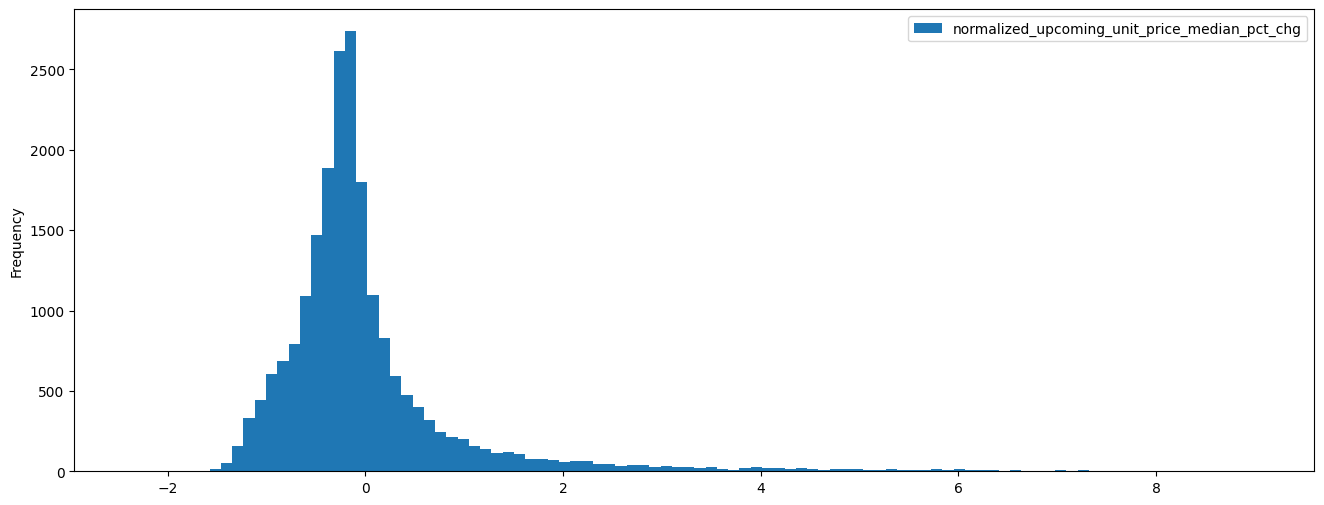

In [126]:
y_train_df.plot.hist(bins=100, figsize=(16, 6))

<Axes: ylabel='Frequency'>

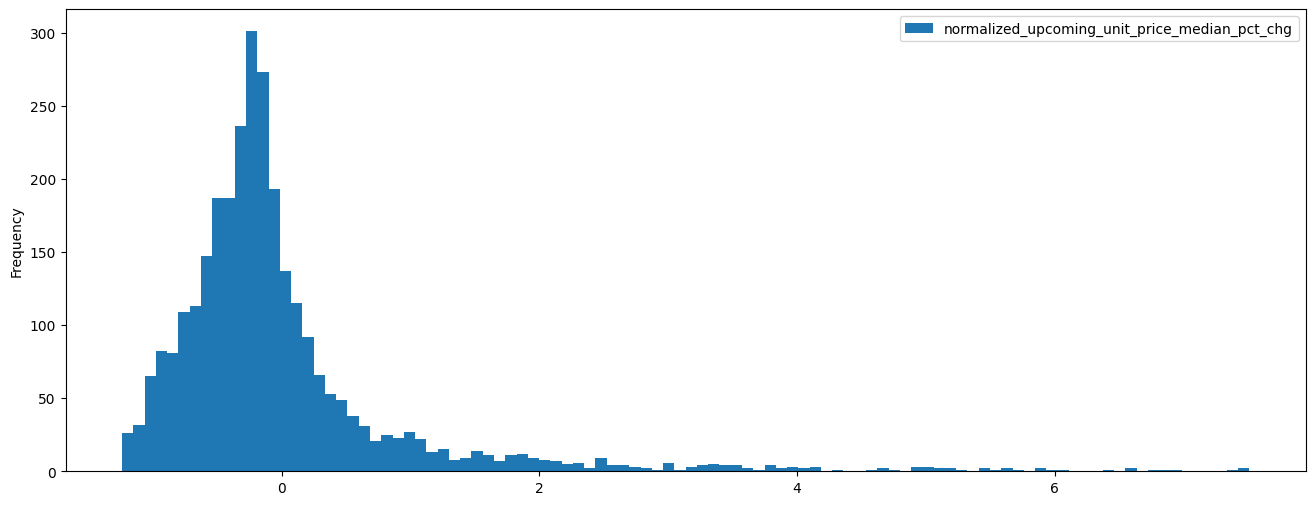

In [127]:
y_test_df.plot.hist(bins=100, figsize=(16, 6))


In [128]:
pretraining_dataset = "plps"
pretrained_model_path = f"{WEIGHTS_DIRECTORY_PATH}/xgb_{pretraining_dataset}_{metric_key}.json"

xgb_regressor = XGBRegressor(
    tree_method="hist", early_stopping_rounds=4, enable_categorical=True
)

# xgb_regressor = XGBRegressor(
#     tree_method="hist", enable_categorical=True
# )

# xgb_regressor.load_model(pretrained_model_path)

In [129]:
xgb_regressor.fit(X_train_df, y_train_df, eval_set=[(X_test_df, y_test_df)])

y_train_pred = xgb_regressor.predict(X_train_df)
y_test_pred = xgb_regressor.predict(X_test_df)

print()
print(f"Train RMSE: {mean_squared_error(y_train_df, y_train_pred, squared=False):.4f}")
print(f"Test RMSE: {mean_squared_error(y_test_df, y_test_pred, squared=False):.4f}")

print(f"Train R2: {r2_score(y_train_df.values.squeeze(), y_train_pred):.4f}")
print(f"Test R2: {r2_score(y_test_df.values.squeeze(), y_test_pred):.4f}")

[0]	validation_0-rmse:0.94904
[1]	validation_0-rmse:0.92790


[2]	validation_0-rmse:0.91533
[3]	validation_0-rmse:0.90572
[4]	validation_0-rmse:0.90386
[5]	validation_0-rmse:0.90364
[6]	validation_0-rmse:0.90597
[7]	validation_0-rmse:0.90786
[8]	validation_0-rmse:0.90756

Train RMSE: 0.7967
Test RMSE: 0.9036
Train R2: 0.3648
Test R2: 0.1829


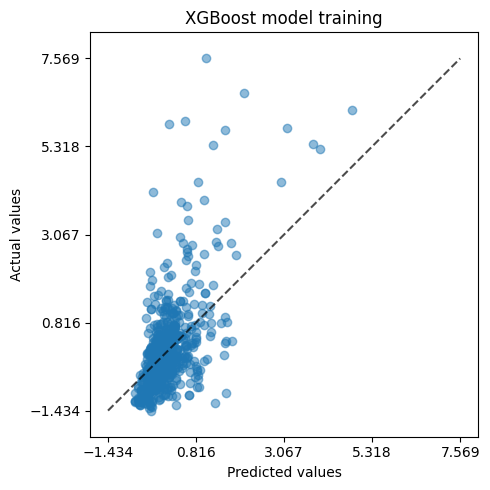

In [130]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_train_df.values.squeeze(),
    y_train_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model training")
plt.tight_layout()

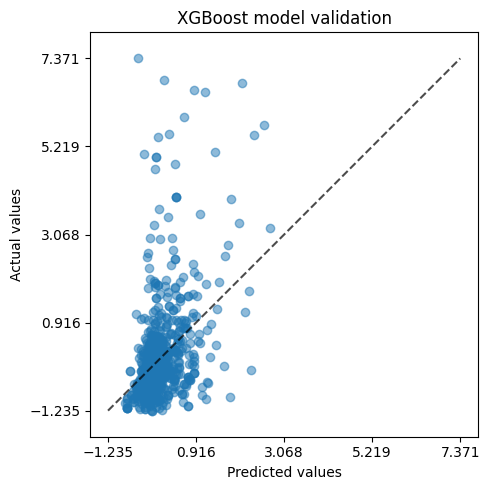

In [131]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test_df.values.squeeze(),
    y_test_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model validation")
plt.tight_layout()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

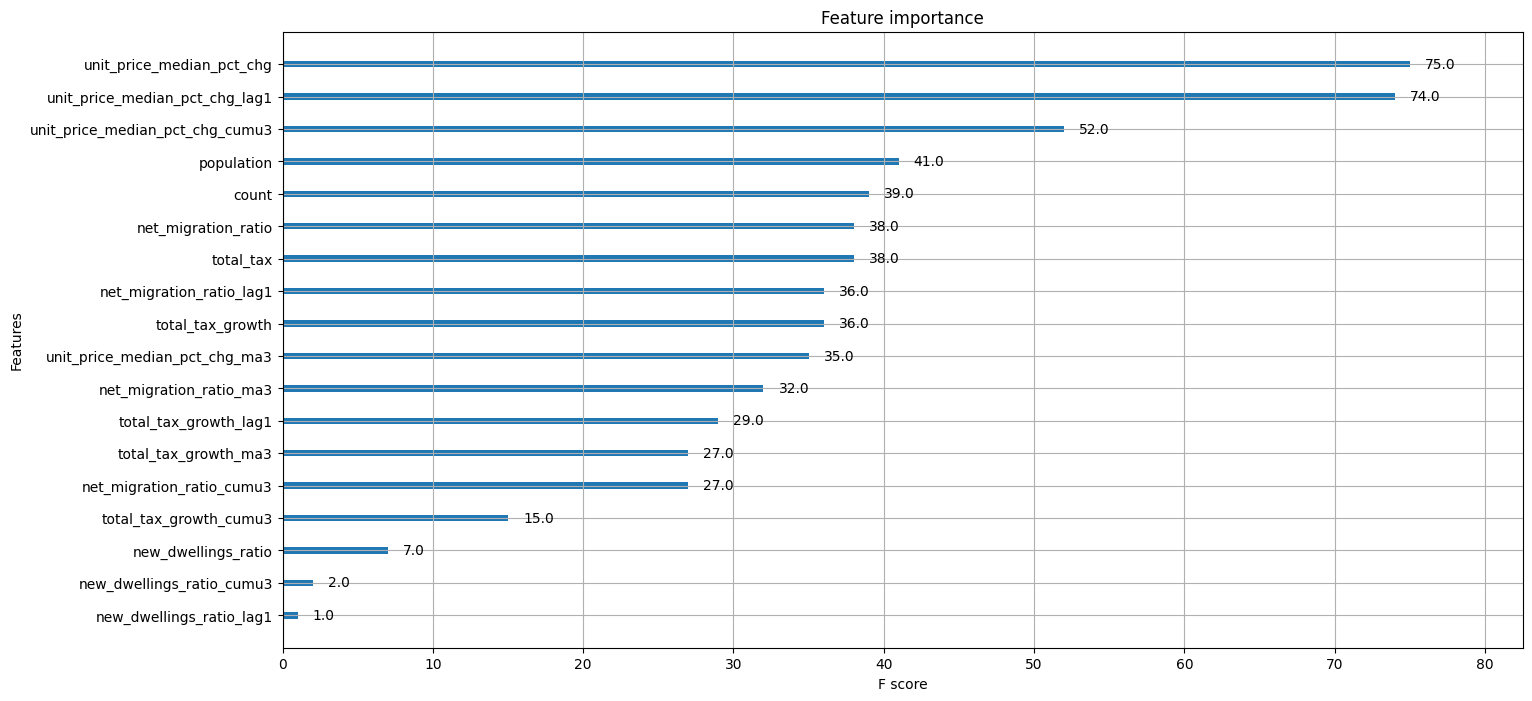

In [132]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(xgb_regressor)